In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("interception_events_old.csv", index_col=0)

In [3]:
df_sel = df.dropna(subset=[f"{i}_x" for i in range(22)] + ["target_player"])

## Definindo parâmetros

In [4]:
recep_x = []
recep_y = []

players_id = [f"{i}_player_id" for i in range(22)]

for i, row in df_sel.iterrows():
    for c in players_id:
        if row[c] == row["target_player"]:
            i = c.split("_")[0]
            recep_x.append(row[f"{i}_x"])
            recep_y.append(row[f"{i}_y"])
            break
    else:
        recep_x.append(np.nan)
        recep_y.append(np.nan)

df_sel.loc[:, "receptor_x"] = np.array(recep_x)
df_sel.loc[:, "receptor_y"] = np.array(recep_y)

df_sel = df_sel.dropna(subset=["receptor_x"])

C:\Users\tonim\AppData\Local\Temp\ipykernel_7828\2100708124.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sel.loc[:, "receptor_x"] = np.array(recep_x)
C:\Users\tonim\AppData\Local\Temp\ipykernel_7828\2100708124.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sel.loc[:, "receptor_y"] = np.array(recep_y)


In [5]:
A = df_sel[["ball_x", "ball_y"]].values
B = df_sel[["receptor_x", "receptor_y"]].values

for k in range(22):
    projector = []
    P = df_sel[[f"{k}_x", f"{k}_y"]].values
    
    for i in range(len(A)):
        a, b, p = A[i], B[i], P[i]
        ab = b - a
        ap = p - a
        
        t = np.dot(ap, ab) / np.dot(ab, ab)
        projector.append(a + t*ab)

    projector = np.array(projector)
    df_sel[f"{k}_projection_x"] = projector[:, 0]
    df_sel[f"{k}_projection_y"] = projector[:, 1]

C:\Users\tonim\AppData\Local\Temp\ipykernel_7828\796227054.py:13: RuntimeWarning: invalid value encountered in scalar divide
  t = np.dot(ap, ab) / np.dot(ab, ab)
C:\Users\tonim\AppData\Local\Temp\ipykernel_7828\796227054.py:13: RuntimeWarning: invalid value encountered in scalar divide
  t = np.dot(ap, ab) / np.dot(ab, ab)
C:\Users\tonim\AppData\Local\Temp\ipykernel_7828\796227054.py:13: RuntimeWarning: invalid value encountered in scalar divide
  t = np.dot(ap, ab) / np.dot(ab, ab)
C:\Users\tonim\AppData\Local\Temp\ipykernel_7828\796227054.py:13: RuntimeWarning: invalid value encountered in scalar divide
  t = np.dot(ap, ab) / np.dot(ab, ab)
C:\Users\tonim\AppData\Local\Temp\ipykernel_7828\796227054.py:13: RuntimeWarning: invalid value encountered in scalar divide
  t = np.dot(ap, ab) / np.dot(ab, ab)
C:\Users\tonim\AppData\Local\Temp\ipykernel_7828\796227054.py:13: RuntimeWarning: invalid value encountered in scalar divide
  t = np.dot(ap, ab) / np.dot(ab, ab)
C:\Users\tonim\AppData

In [6]:
df_sel = df_sel.dropna(subset=[f"{i}_projection_x" for i in range(22)])

In [23]:
def calculate_time_for_ball_reach_point(A, B, Q, P):
    xi, yi = A
    xf, yf = B
    xp, yp = Q

    d = np.linalg.norm(Q)
    v = 15
    t = d / v
    
    if np.linalg.norm(Q-P) > 3*t: 
        return -1
    return t

In [19]:
def new_position_for_player(p, q, v, t):
    REACTION_TIME = 0.7
    VELOCITY = 3
    EPLISON = 10e-8
    
    if t <= REACTION_TIME: return p

    pv = q - p

    if np.linalg.norm(pv) * np.linalg.norm(v) < EPLISON:
        cos_theta = 0
    else:
        cos_theta = np.dot(pv, v) / (np.linalg.norm(pv) * np.linalg.norm(v))
        
    alpha = np.degrees(np.arccos(cos_theta))
    
    if alpha == np.nan: alpha = 0
    
    punition_time = alpha / 120

    new_t = t - punition_time - REACTION_TIME

    if new_t < 0: return p

    direction = pv / (np.linalg.norm(pv) + EPLISON)

    new_pos = p + direction * VELOCITY * new_t

    if (q[0] > p[0] and new_pos[0] > q[0]) or (p[0] > q[0] and new_pos[0] < q[0]):
        return q
    return new_pos

In [25]:
A = df_sel[["ball_x", "ball_y"]].values
B = df_sel[["receptor_x", "receptor_y"]].values

for k in range(22):
    P = df_sel[[f"{k}_x", f"{k}_y"]].values
    Q = df_sel[[f"{k}_projection_x", f"{k}_projection_y"]].values
    V = df_sel[[f"{k}_vx", f"{k}_vy"]].values
    
    new_pos = []
    for i in range(len(P)):
        time = calculate_time_for_ball_reach_point(A[i], B[i], Q[i], P[i])
    
        if time < 0: new_pos.append(P[i])
        else:
            new_pos.append(new_position_for_player(P[i], Q[i], V[i], time))

    new_pos = np.array(new_pos)
    df_sel[f"{k}_new_x"] = new_pos[:, 0]
    df_sel[f"{k}_new_y"] = new_pos[:, 1]

In [26]:
df_sel = df_sel.dropna(subset=[f"{i}_new_x" for i in range(22)])

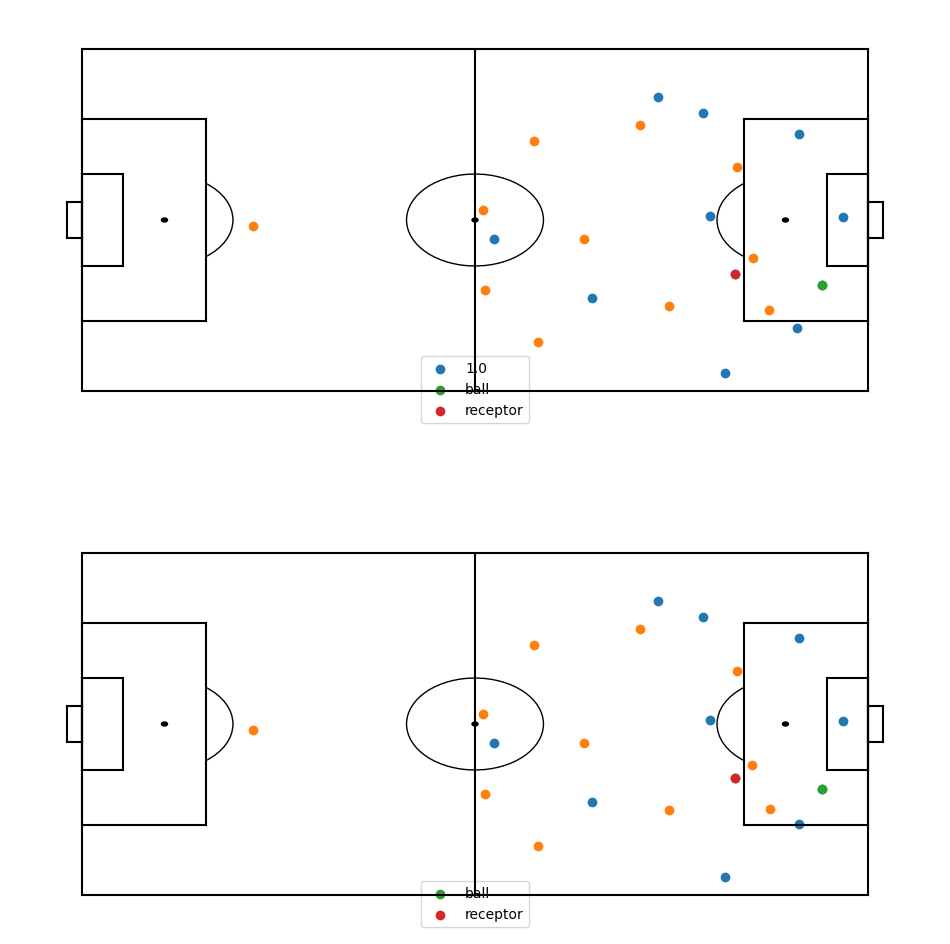

In [27]:
import matplotsoccer

fig, ax = plt.subplots(2, 1, figsize=(12, 12))

row = df_sel.loc[4, :]

xi_home = row[[f"{i}_x" for i in range(11)]] + 52.5
yi_home = row[[f"{i}_y" for i in range(11)]] + 34
xi_away = row[[f"{i}_x" for i in range(11, 22)]] + 52.5
yi_away = row[[f"{i}_y" for i in range(11, 22)]] + 34

xn_home = row[[f"{i}_new_x" for i in range(11)]] + 52.5
yn_home = row[[f"{i}_new_y" for i in range(11)]] + 34
xn_away = row[[f"{i}_new_x" for i in range(11, 22)]] + 52.5
yn_away = row[[f"{i}_new_y" for i in range(11, 22)]] + 34

matplotsoccer.field(show=False, ax=ax[0])
ax[0].scatter(xi_home, yi_home, label=row["home_ball"])
ax[0].scatter(xi_away, yi_away)
ax[0].scatter((row["ball_x"] + 52.5), (row["ball_y"] + 34), label="ball")
ax[0].scatter((row["receptor_x"] + 52.5), (row["receptor_y"] + 34), label="receptor")

matplotsoccer.field(show=False, ax=ax[1])
ax[1].scatter(xn_home, yn_home)
ax[1].scatter(xn_away, yn_away)
ax[1].scatter((row["ball_x"] + 52.5), (row["ball_y"] + 34), label="ball")
ax[1].scatter((row["receptor_x"] + 52.5), (row["receptor_y"] + 34), label="receptor")

ax[0].legend()
ax[0].axis("off")

ax[1].legend()
ax[1].axis("off")

plt.show()

## Testes

In [18]:
df_sel.loc[4, ["pass_outcome_type"]]

pass_outcome_type    C
Name: 4, dtype: object

In [78]:
P = df_sel.loc[2, ["16_new_x", "16_new_y"]].values
V = df_sel.loc[2, ["16_vx", "16_vy"]].values
Q = df_sel.loc[2, ["16_projection_x", "16_projection_y"]].values

ball = df_sel.loc[2, ["ball_x", "ball_y"]].values
receptor = df_sel.loc[2, ["receptor_x", "receptor_y"]].values

new_position_for_player(P, Q, V, calculate_time_for_ball_reach_point(ball, receptor, Q, P))

3.0691684579780962


array([13.44, -11.526], dtype=object)

## Salvando

In [126]:
new_df = df_sel.copy()

new_df = new_df.drop([f"{i}_x" for i in range(22)] + [f"{i}_y" for i in range(22)], axis=1)

new_df = new_df.rename(columns={
    **{f"{i}_new_x": f"{i}_x" for i in range(22)},
    **{f"{i}_new_y": f"{i}_y" for i in range(22)},
})

In [127]:
df_to_save = new_df.drop( 
    [f"{i}_projection_x" for i in range(22)] + [f"{i}_projection_y" for i in range(22)], 
    axis=1
)

In [129]:
df_to_save.to_csv("interception_temporal_events.csv")